In [772]:
#!/usr/bin/env python
# coding: utf-8

"""
Title: Linear Regression Practice
Client: n/a
Date: 4/29/2024
Author: Myles Thomas
"""

import sys
import os
import threading
import timeit
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from helper_functions import remove_na, remove_duplicates

# sys.path.append(os.path.abspath("/home/ec2-user/SageMaker/odp-sagemaker-notebooks/src"))
# sys.path.insert(0, "/home/ec2-user/SageMaker/odp-metrics")

LOGGER = logging.getLogger(__name__)
LOGGER.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(levelname)s: %(message)s')
stream_handler.setFormatter(formatter)
LOGGER.addHandler(stream_handler)

start_of_script_time = (
    timeit.default_timer()
)  # remove this block AND last block before sending into Production

SCRIPT_DIR = os.getcwd()
PARENT_DIR = os.path.dirname(SCRIPT_DIR)
INPUT_DIR = os.path.join(PARENT_DIR, "00_INPUT/")
INTER_DIR = os.path.join(PARENT_DIR, "01_INTERMEDIATE/")
OUTPUT_DIR = os.path.join(PARENT_DIR, "02_OUTPUT/")

LOGGER.info(f"script directory: {SCRIPT_DIR}")

FILENAME_TRAINING_DATA = "TRAINING_DATA.txt"
FILENAME_TRAINING_DATA_WITH_PATH = os.path.join(INPUT_DIR, FILENAME_TRAINING_DATA)

FILENAME_TESTING_DATA = "TESTING_DATA.txt"
FILENAME_TESTING_DATA_WITH_PATH = os.path.join(INPUT_DIR, FILENAME_TESTING_DATA)

map_input_file_to_pandas_training_data = {
    "so2": "y",
    "car.count": "car_count",
    "wind.velocity": "wind_velocity",
    "wind.direction": "wind_direction",
    "time.of.day": "time_of_day",
    "day.index": "day_index",
    "temperature.1": "temperature_1",
    "temperature.30": "temperature_30",
}

map_input_file_to_pandas_training_data_dtypes = {
    "y": np.float32,
    "car_count": np.float32,
    "wind_velocity": np.float32,
    "wind_direction": np.int32,
    "time_of_day": "category",
    "day_index": np.int32,
    "temperature_1": np.float32,
    "temperature_30": np.float32,
}

map_input_file_to_pandas_testing_data = map_input_file_to_pandas_training_data.copy()
map_input_file_to_pandas_testing_data.pop("so2")
map_input_file_to_pandas_testing_data_dtypes = map_input_file_to_pandas_training_data_dtypes.copy()
map_input_file_to_pandas_testing_data_dtypes.pop("y")

2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,938 INFO: script directory: c:\Users\Myles\linear_regression_practice\03_CODE
2024-05-01 10:07:59,

numpy.float32

In [773]:
def get_data(train_or_test):
    """Returns the training and test data for this analysis

    inputs:
    - train_or_test: str

    outputs:
    - df: pandas DataFrame
    """
    if train_or_test == "train":
        df_train = pd.read_csv(
            FILENAME_TRAINING_DATA_WITH_PATH,
            header=0,
            usecols=map_input_file_to_pandas_training_data.keys(),
            # dtype=map_input_file_to_pandas_training_data_dtypes
        ).rename(columns=map_input_file_to_pandas_training_data)
        # print(df_train.dtypes)
        df_train = df_train.astype(map_input_file_to_pandas_training_data_dtypes)
        # print(df_train.dtypes)
        return df_train
    
    elif train_or_test == "test":
        df_test = pd.read_csv(
            FILENAME_TESTING_DATA_WITH_PATH,
            header=0,
            usecols=map_input_file_to_pandas_testing_data.keys(),
            dtype=map_input_file_to_pandas_testing_data_dtypes
        ).rename(columns=map_input_file_to_pandas_testing_data)
        df_test = df_test.astype(map_input_file_to_pandas_testing_data_dtypes)
        return df_test
    
    else:
        raise ValueError(f"Invalid Input: Expected `train` OR `test`, got {train_or_test}.")

def clean_data(df):
    """Ensures that the data is ready for Exploratory Data Analysis (EDA)
    inputs:
    - df: pandas DataFrame

    outputs:
    - df_clean: pandas DataFrame
    """
    df_no_na = remove_na(df)
    df_clean = remove_duplicates(df_no_na)
    return df_clean

In [774]:
df_train = get_data(train_or_test="train")
df_train


,y,car_count,wind_velocity,wind_direction,time_of_day,day_index,temperature_1,temperature_30
0,169.099960,1430.000366,1.3,114,21,50,-1.7,-0.3
1,51.000221,2328.989990,2.5,83,20,98,-5.4,-4.0
2,20.299982,2884.999512,2.2,44,18,189,9.8,9.8
3,68.799744,3542.011230,5.9,214,16,108,4.2,4.5
4,82.000061,2531.000488,0.5,296,15,184,8.9,8.3
...,...,...,...,...,...,...,...,...
295,15.400039,455.998718,2.9,196,1,125,4.5,5.1
296,93.899963,3872.981934,3.4,248,8,43,1.0,2.3
297,23.400093,338.001373,4.3,203,1,127,4.6,4.9
298,51.299961,334.999817,2.1,79,3,83,-9.1,-8.5


In [775]:
df_train = clean_data(df_train)
df_train

No NA values found.
Duplicate rows found. Removing them...


,y,car_count,wind_velocity,wind_direction,time_of_day,day_index,temperature_1,temperature_30
16,34.100090,114.000175,2.4,80,3,200,2.9,3.5
23,43.799831,2432.999268,4.8,223,11,178,5.7,4.2
24,137.599869,3157.986816,1.3,152,9,36,2.3,2.8
25,38.500069,2900.011475,3.7,16,18,116,-4.8,-4.8
26,55.400021,3852.008545,3.1,225,17,207,8.4,7.9
...,...,...,...,...,...,...,...,...
295,15.400039,455.998718,2.9,196,1,125,4.5,5.1
296,93.899963,3872.981934,3.4,248,8,43,1.0,2.3
297,23.400093,338.001373,4.3,203,1,127,4.6,4.9
298,51.299961,334.999817,2.1,79,3,83,-9.1,-8.5


In [776]:
df_train.dtypes

y                  float32
car_count          float32
wind_velocity      float32
wind_direction       int32
time_of_day       category
day_index            int32
temperature_1      float32
temperature_30     float32
dtype: object

y
float32
car_count
float32
wind_velocity
float32
wind_direction
int32
time_of_day
category
day_index
int32
temperature_1
float32
temperature_30
float32


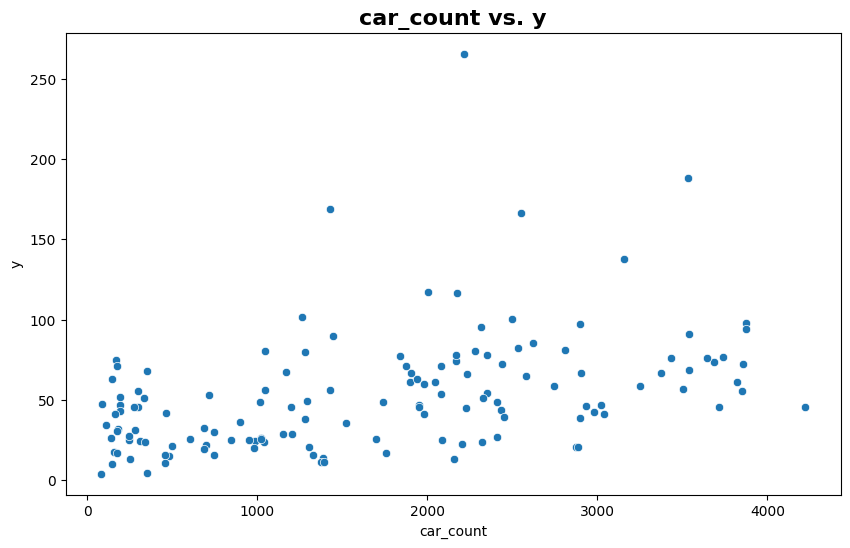

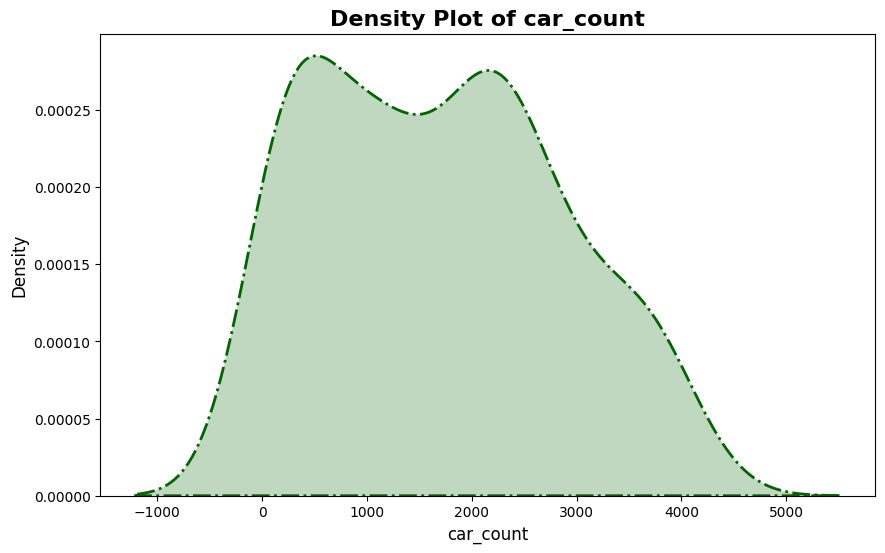

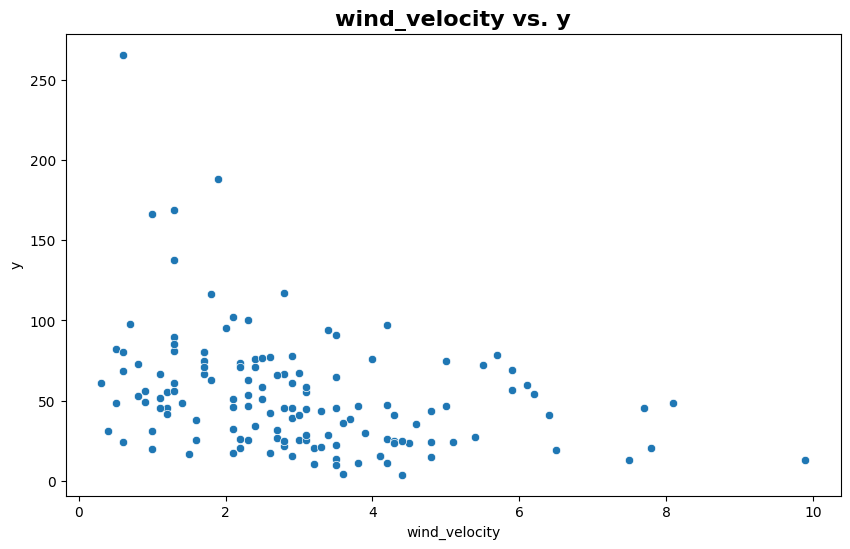

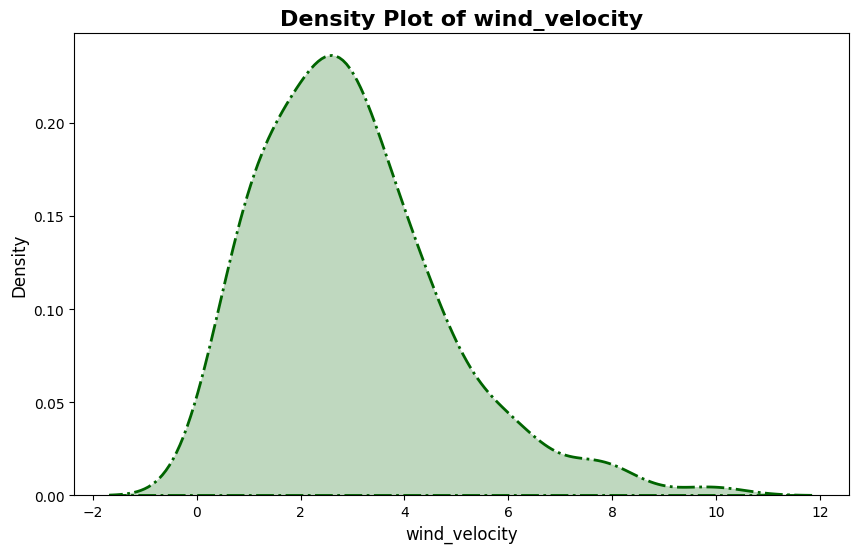

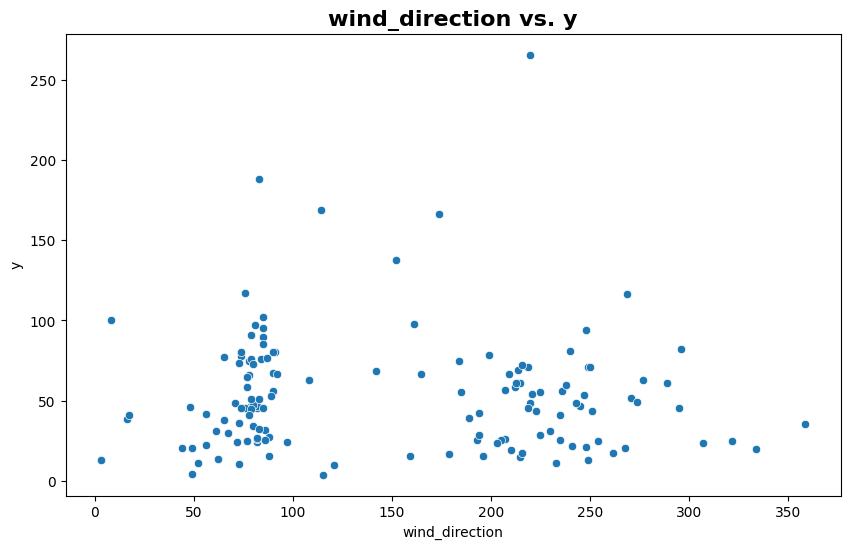

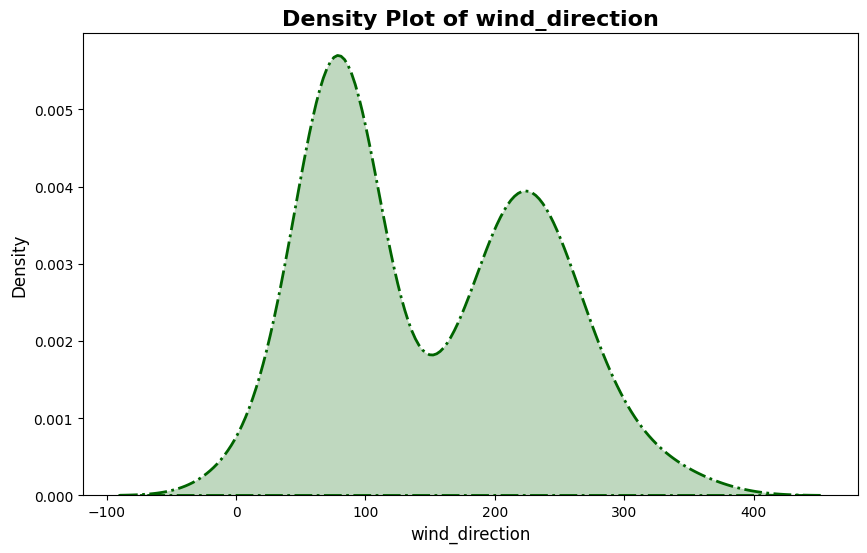

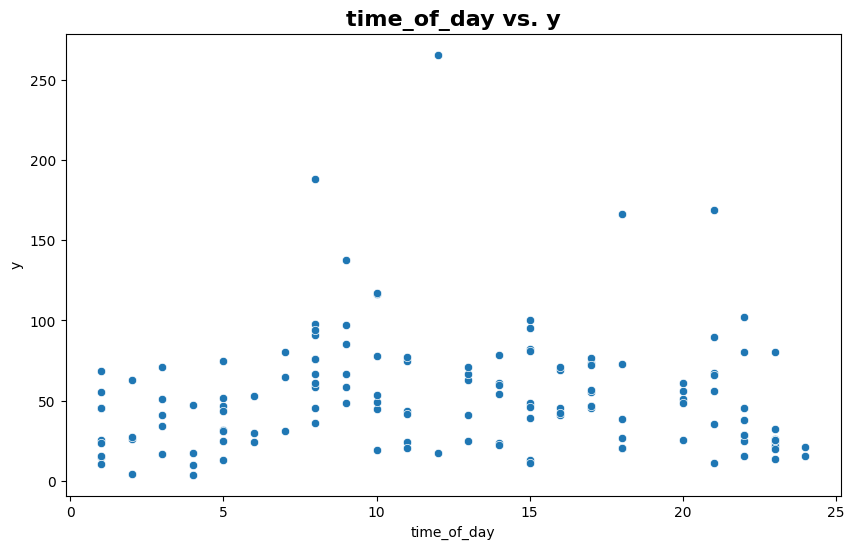

<Figure size 1000x600 with 0 Axes>

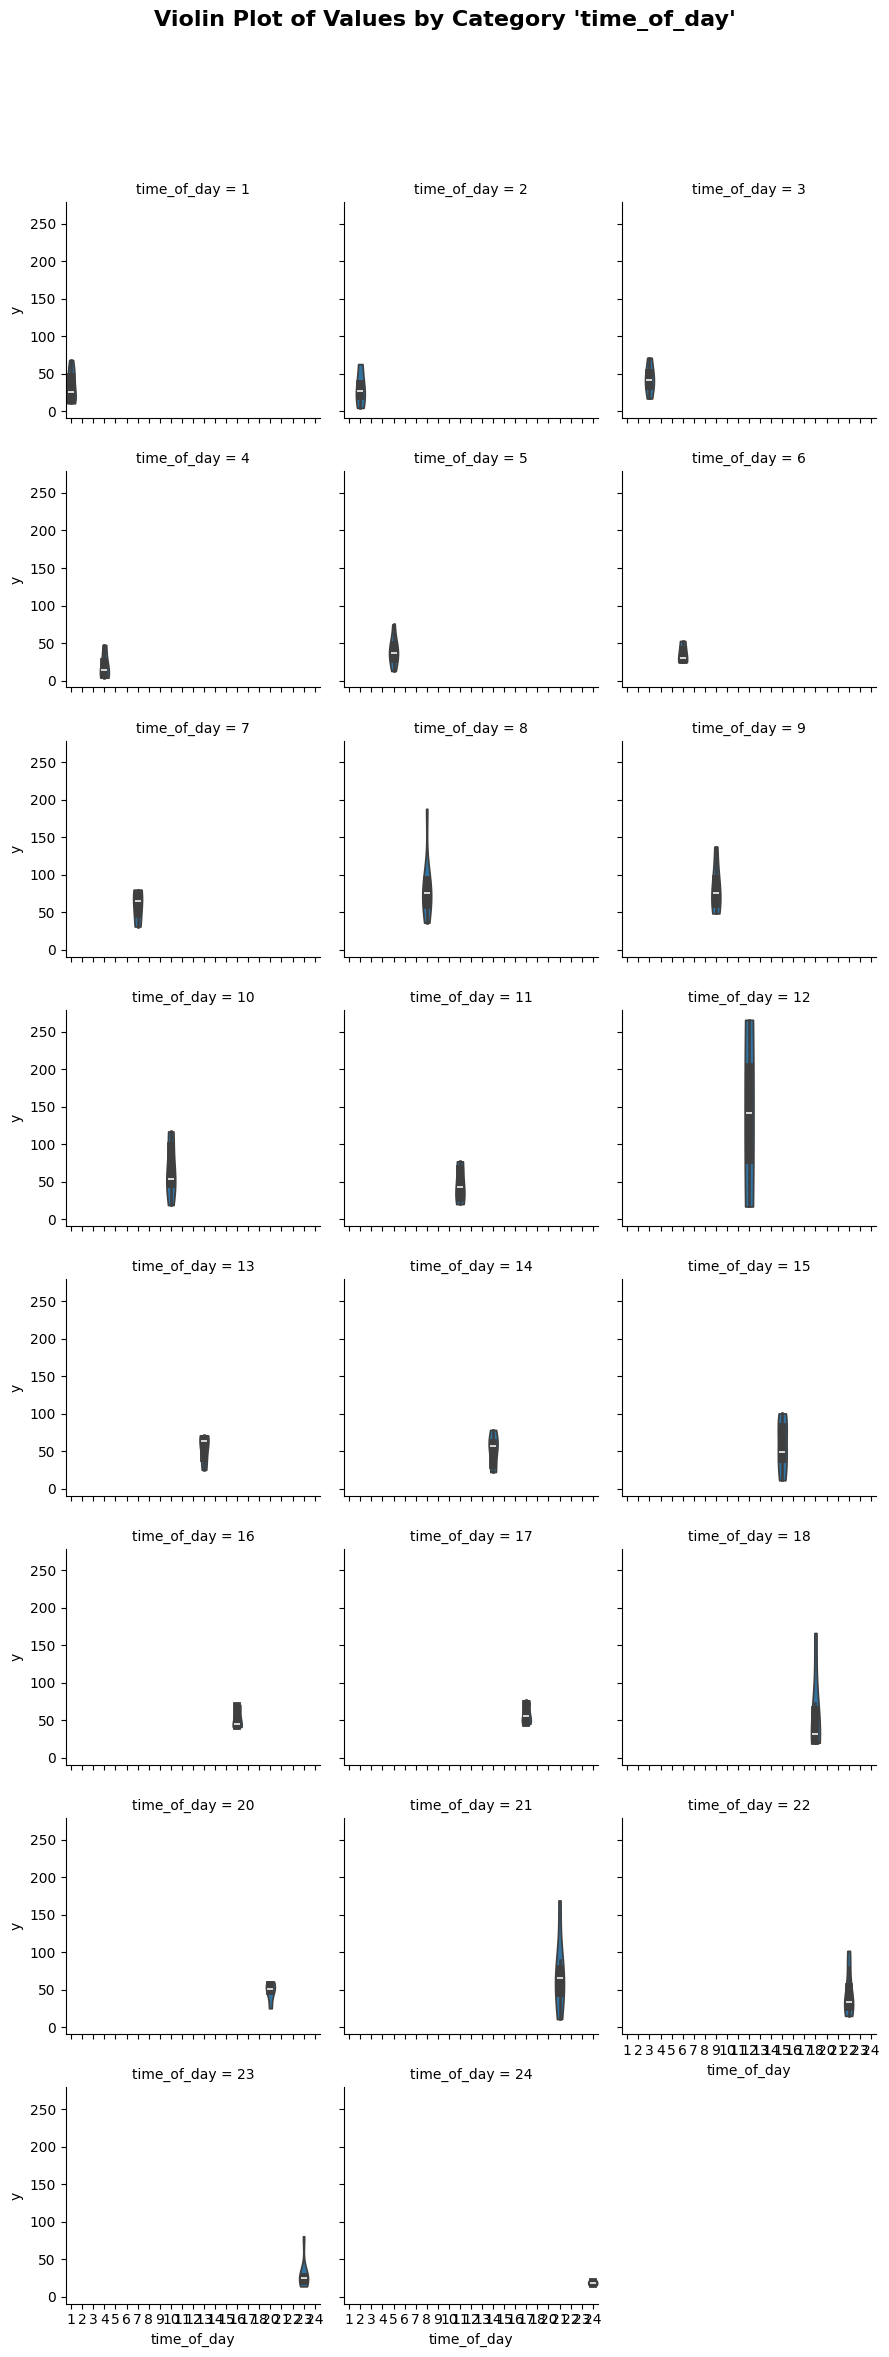

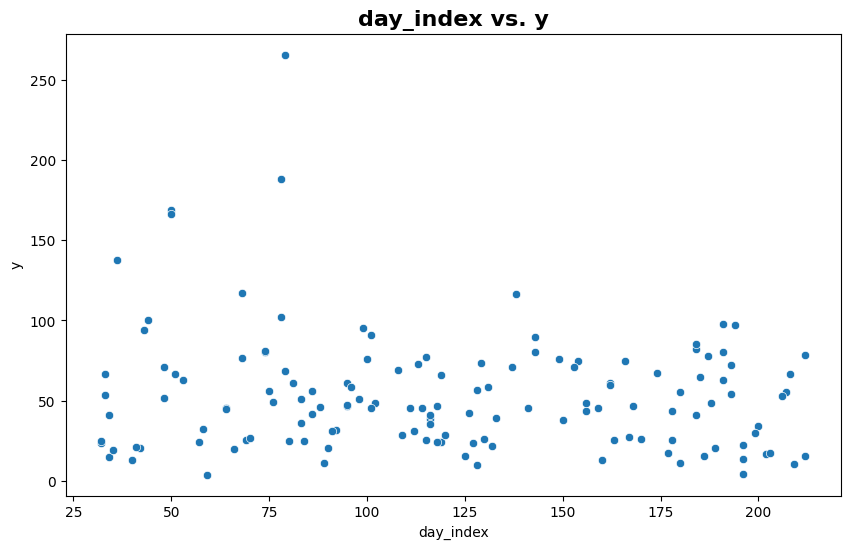

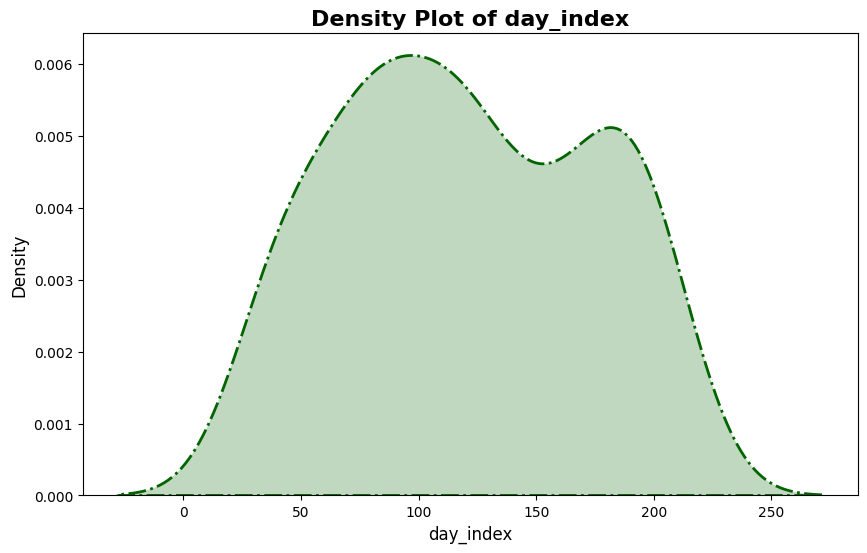

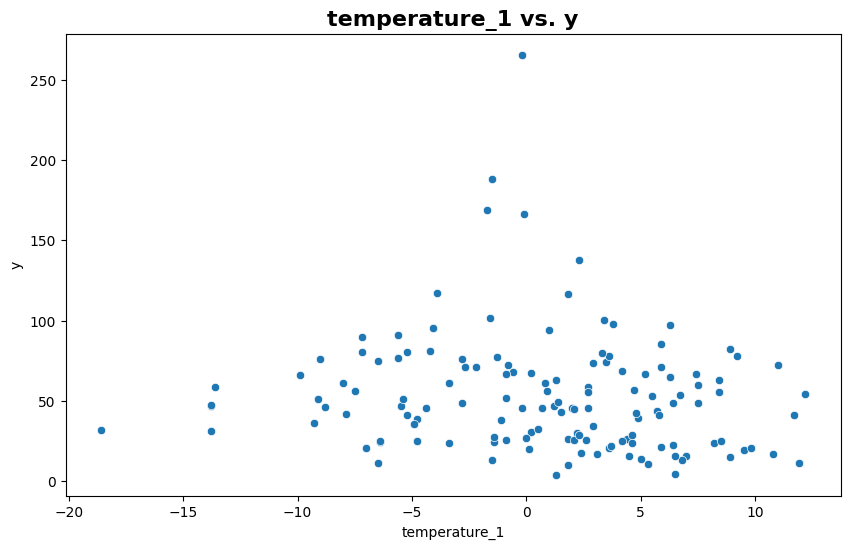

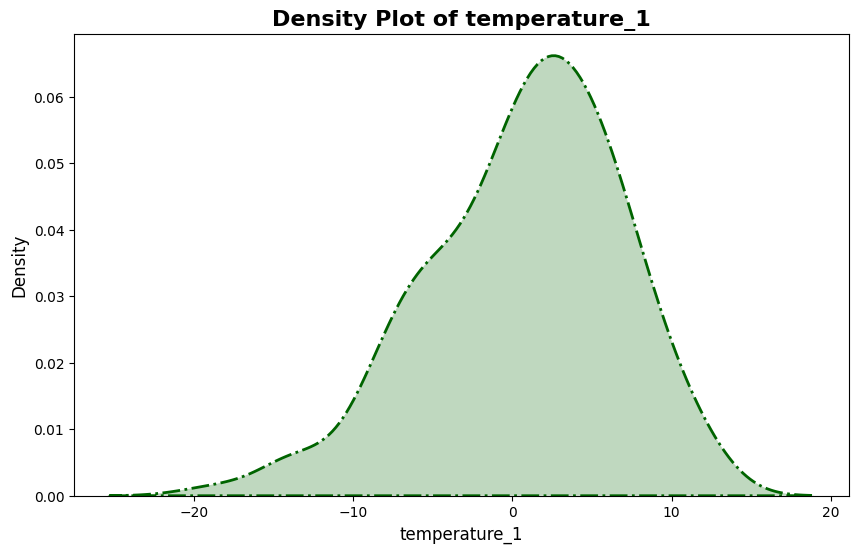

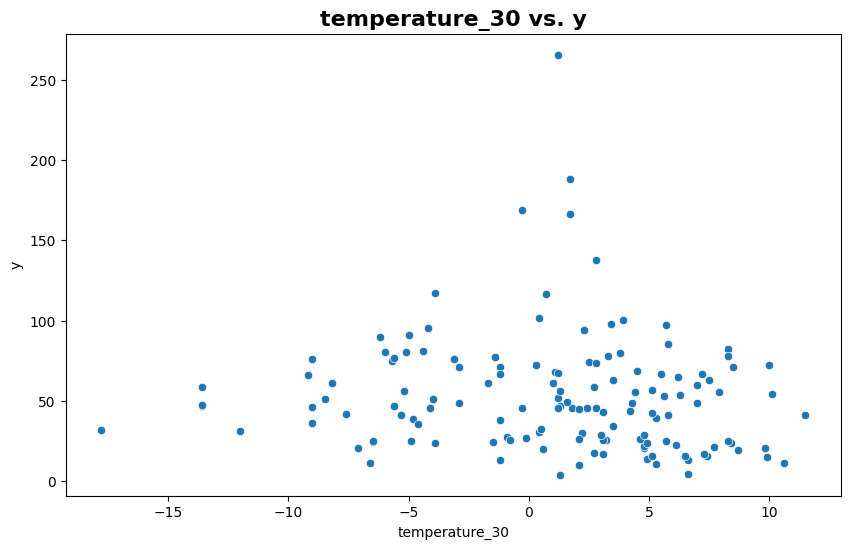

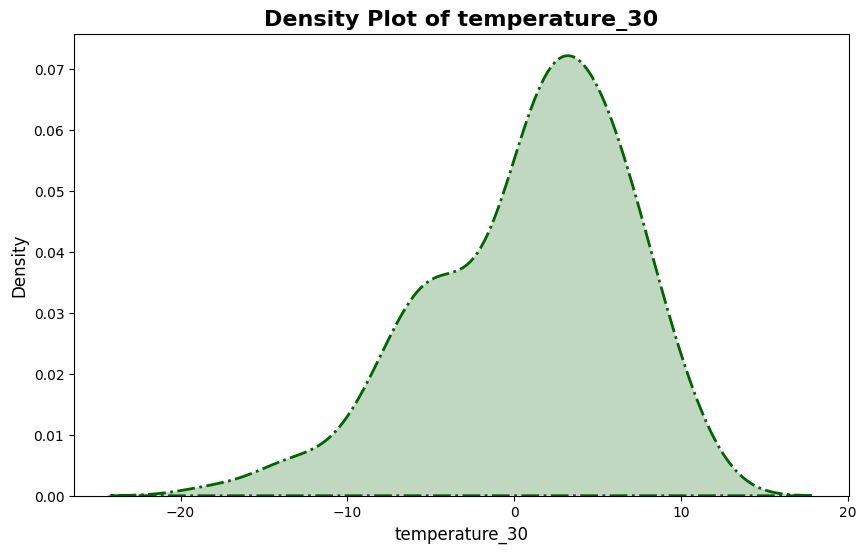

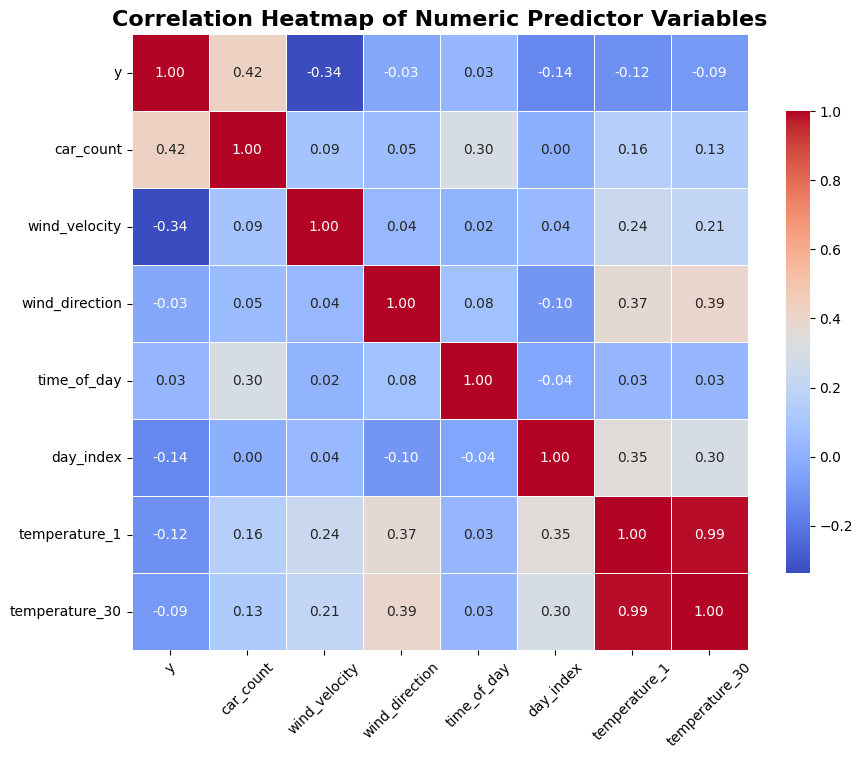

In [777]:
def save_describe_as_image(df, filename="describe_table.png"):
    """
    Saves the statistical summary (from DataFrame.describe()) as a .png image.

    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.
    filename (str): The filename to save the image as.
    """
    # Create a figure and an axis to plot
    fig, ax = plt.subplots(figsize=(12, 6))  # You can adjust the size as needed

    # Hide the axes
    ax.axis('off')
    
    # Calculate the description statistics
    desc = df.describe()
    
    # Create a table and place it on the axes
    table = ax.table(cellText=desc.values, colLabels=desc.columns, rowLabels=desc.index, cellLoc = 'center', loc='center')
    
    # Table style enhancements
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust scaling to your preference
    # table.set_edgecolor('black')  # Add border color
    # table.set_linewidth(0.5)  # Set border width

    # Color the rows for better readability
    # for (i, key), cell in zip(enumerate(desc.index), table._cells):
    #     if i % 2 == 0:
    #         color = '#f1f1f2'  # Light gray for even rows
    #     else:
    #         color = '#ffffff'  # White for odd rows
    #     for j in range(len(desc.columns) + 1):  # Apply to all columns
    #         table._cells[(i, j)].set_facecolor(color)

    # Setting colors and borders for each cell
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('darkgray')  # Setting cell border color
        if key[0] == 0 or key[1] == -1:  # Header or index cells
            cell.set_facecolor('lightsteelblue')
            cell.set_text_props(weight='bold')
        elif key[0] % 2 == 0:
            cell.set_facecolor('whitesmoke')  # Alternate colors for readability
        else:
            cell.set_facecolor('white')

    # Adding a title
    plt.title('Descriptive Statistics of DataFrame', fontsize=16, fontweight='bold', color='darkblue', pad=20)

    # Save the figure
    # plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.savefig(
        os.path.join(OUTPUT_DIR, filename),
        bbox_inches='tight',
        dpi=300
    )
    plt.close()

def save_scatterplot(data, x, y, hue=None):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue
    )

    plt.title(f'{x} vs. {y}', fontsize=16, fontweight='bold')
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    # plt.show()
    plt.savefig(
        fname=os.path.join(OUTPUT_DIR, f"scatterplot-{x}-{y}.png")
    )
    # print(f"saving here...{os.path.join(OUTPUT_DIR, f"scatterplot-{x}-{y}.png")}")

def save_facet_grid_plot(df, x, y):
    plt.figure(figsize=(10, 6))
    # Create a FacetGrid, mapping each category to a separate subplot
    g = sns.FacetGrid(df, col=x, col_wrap=3, sharex=True, sharey=True)  # Adjust col_wrap to fit your number of category levels

    # Applying a violin plot to each subplot
    g.map(sns.violinplot, x, y, order=sorted(df[x].unique()), cut=0)

    # Adding some margin between plots and a title for each subplot (optional)
    g.fig.subplots_adjust(top=0.9)  # Adjust the top margin to give space for suptitle if necessary
    g.fig.suptitle(f"Violin Plot of Values by Category '{x}'", fontsize=16, fontweight='bold')

    # Displaying the plots
    # plt.show()
    plt.savefig(
        fname=os.path.join(OUTPUT_DIR, f"category-{x}.png")
    )

def save_univariate_plot(df, x):
    """"""
    plt.figure(figsize=(10, 6))
    # Creating a KDE plot for the 'Value' column
    sns.kdeplot(data=df[x], fill=True, color='darkgreen', linewidth=2, linestyle='-.')

    # Adding titles and labels (optional but recommended for clarity)
    plt.title(f'Density Plot of {x}', fontsize=16, fontweight='bold')
    plt.xlabel(f'{x}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.savefig(
        fname=os.path.join(OUTPUT_DIR, f"univariate-{x}.png")
    )

def produce_correlation_matrix(df, list_numeric_variables):
    # df = df[list_numeric_variables]
    corr = df.corr()

    # Creating a heatmap
    plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True, cbar_kws={"shrink": .75})

    # Adding titles and labels
    plt.title('Correlation Heatmap of Numeric Predictor Variables', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
    plt.yticks(rotation=0)   # Keeps the y-axis labels horizontal

    # Displaying the plot
    # plt.show()
    plt.savefig(
        fname=os.path.join(OUTPUT_DIR, f"correlation_matrix.png")
    )


def explore_data(df):
    """Perform Exploratory Data Analysis (EDA) on the input data
    
    inputs:
    - df: pandas DataFrame
    """
    save_describe_as_image(df=df_train)

    list_numeric_variables = []
    for col, dtype in zip(df, df.dtypes):
        print(col)
        print(dtype)
        if col == "y":
            continue

        save_scatterplot(
            data=df,
            x=col,
            y="y"
            # hue=hue
        )

        if dtype == "category":
            # categorical: save facet grid plot
            save_facet_grid_plot(df, col, "y")
        else:
            # numeric: save univariate plot
            list_numeric_variables.append(col)
            save_univariate_plot(df, col)
    
    # Produce a correlation heatmap with only numeric variables
    produce_correlation_matrix(df, list_numeric_variables)

explore_data(df_train)


In [778]:
def transform_day_index_into_day_of_week(df):
    """Remove the day_index column and replace it with a day_of_week column

    inputs:
    - df: pandas DataFrame

    outputs:
    - df: pandas DataFrame
    """
    # print(df['day_index'].value_counts(dropna=False))

    # Apply np.where to create the 'day_of_week' column based on 'day_index' modulo 7
    conditions = [
        df['day_index'] % 7 == 1,
        df['day_index'] % 7 == 2,
        df['day_index'] % 7 == 3,
        df['day_index'] % 7 == 4,
        df['day_index'] % 7 == 5,
        df['day_index'] % 7 == 6,
        df['day_index'] % 7 == 0,
    ]
    choices = [
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday'
    ]

    df['day_of_week'] = np.select(conditions, choices, default=np.nan)  # default can be set to any value that makes sense in your context

    df.drop("day_index", axis=1, inplace=True)

    # print(df['day_of_week'].value_counts(dropna=False))
    return df

def get_dummy_variables(df, cols_to_dummy):
    """
    Turn the dataframe into a dummy dataframe, ready for ML modeling.
    inputs:
    - df: pandas DataFrame

    inputs:
    - df_dummy: pandas DataFrame
    """
    df_dummy = pd.get_dummies(
        df,
        columns=cols_to_dummy,
        drop_first=True,
        dtype=int
    )
    return df_dummy

def prepare_data_for_modeling(df):
    """Perform feature engineering and dimension reduction

    inputs:
    - df: pandas DataFrame

    outputs:
    - df: pandas DataFrame
    """
    df = transform_day_index_into_day_of_week(df)
    # df.drop("day_index", axis=1, inplace=True)
    # df = get_dummy_variables(df, cols_to_dummy=['time_of_day', 'day_of_week'])
    df = get_dummy_variables(df, cols_to_dummy=[
        # 'time_of_day',
        'day_of_week',
        ]
    )
    
    return df

df_train = prepare_data_for_modeling(df_train)
df_train


C:\Users\Myles\AppData\Local\Temp\ipykernel_11868\3981954461.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = np.select(conditions, choices, default=np.nan)  # default can be set to any value that makes sense in your context
C:\Users\Myles\AppData\Local\Temp\ipykernel_11868\3981954461.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("day_index", axis=1, inplace=True)


,y,car_count,wind_velocity,wind_direction,time_of_day,temperature_1,temperature_30,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
16,34.100090,114.000175,2.4,80,3,2.9,3.5,0,0,0,1,0,0
23,43.799831,2432.999268,4.8,223,11,5.7,4.2,0,0,0,0,0,1
24,137.599869,3157.986816,1.3,152,9,2.3,2.8,1,0,0,0,0,0
25,38.500069,2900.011475,3.7,16,18,-4.8,-4.8,0,0,0,1,0,0
26,55.400021,3852.008545,3.1,225,17,8.4,7.9,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15.400039,455.998718,2.9,196,1,4.5,5.1,0,1,0,0,0,0
296,93.899963,3872.981934,3.4,248,8,1.0,2.3,1,0,0,0,0,0
297,23.400093,338.001373,4.3,203,1,4.6,4.9,1,0,0,0,0,0
298,51.299961,334.999817,2.1,79,3,-9.1,-8.5,0,1,0,0,0,0


In [779]:
df_train.dtypes

y                         float32
car_count                 float32
wind_velocity             float32
wind_direction              int32
time_of_day              category
temperature_1             float32
temperature_30            float32
day_of_week_Monday          int32
day_of_week_Saturday        int32
day_of_week_Sunday          int32
day_of_week_Thursday        int32
day_of_week_Tuesday         int32
day_of_week_Wednesday       int32
dtype: object

In [780]:
# Splitting features and target from training data
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Prepare testing data features
df_test = get_data(train_or_test="test")
df_test = prepare_data_for_modeling(df_test)
df_test

X_test = df_test

# Predict using the trained model
y_pred = model.predict(X_test)

# Since we don't have actual so2 values in the testing data, I'll split some data from training for validation purposes
X_train_split, X_validate, y_train_split, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Re-fit the model using split training data
model.fit(X_train_split, y_train_split)

# Validate using the validation set
y_validate_pred = model.predict(X_validate)

# Calculate metrics
mse = mean_squared_error(y_validate, y_validate_pred)
r2 = r2_score(y_validate, y_validate_pred)

print("Mean Squared Error:", mse)
print("R-Squared:", r2)


Mean Squared Error: 1931.645019047831
R-Squared: 0.2579119404926685


In [781]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Load data
# boston = load_boston()
# X = pd.DataFrame(boston.data, columns=boston.feature_names)
# y = pd.DataFrame(boston.target, columns=["MEDV"])

X = df_train.drop('y', axis=1)
y = df_train['y']
X
y

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize and fit the model
lr = LinearRegression()
sfs = SFS(lr, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

sfs = sfs.fit(X_train, y_train)

# Print the names of the selected features
selected_features = X_train.columns[list(sfs.k_feature_idx_)]
print(selected_features)




c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\U

c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Myles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\U

Index(['car_count', 'wind_velocity', 'temperature_1', 'temperature_30',
       'day_of_week_Monday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday'],
      dtype='object')


In [782]:
sfs

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(1, 12),
                          scoring='neg_mean_squared_error')

In [783]:
sfs.k_feature_names_

('car_count',
 'wind_velocity',
 'temperature_1',
 'temperature_30',
 'day_of_week_Monday',
 'day_of_week_Sunday',
 'day_of_week_Thursday',
 'day_of_week_Tuesday')

In [784]:
sfs.k_features

(1, 12)

In [785]:
# Using just the best predictors...
list_best_predictors = list(sfs.k_feature_names_)
print(list_best_predictors)

['car_count', 'wind_velocity', 'temperature_1', 'temperature_30', 'day_of_week_Monday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday']


In [786]:
# Train the model on the training data using only the selected features
X = X_train[list_best_predictors]
y = y_train
lr.fit(X, y)

# Evaluate the model on the test set
y_pred = lr.predict(X_test[list_best_predictors])

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-Squared:", r2)


Mean Squared Error: 1169.2300953704241
R-Squared: 0.3859777779256762


In [787]:
def train_model(df_train):
    """
    """
    pass
    

# lr_model = train_model(df_train)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     14.09
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.35e-14
Time:                        10:08:17   Log-Likelihood:                -650.22
No. Observations:                 138   AIC:                             1318.
Df Residuals:                     129   BIC:                             1345.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   43.3404 

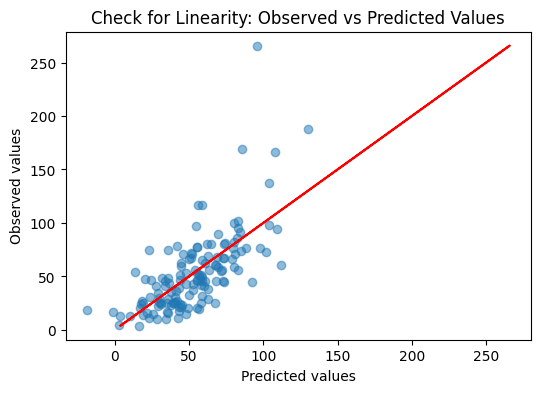

Rainbow test statistic: 1.7522451479796126, p-value: 0.013765778119068532


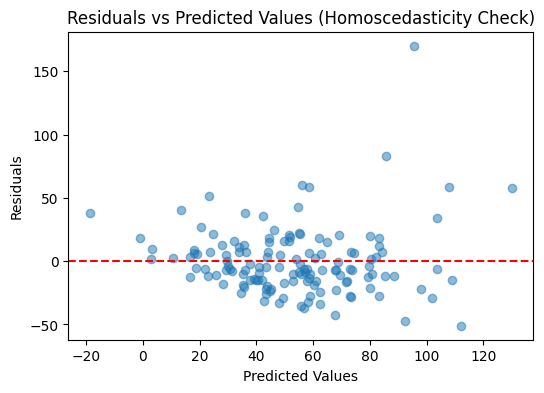

{'Lagrange Multiplier statistic': 9.819894605022387, 'p-value': 0.27789526848645496, 'f-value': 1.2353383547162404, 'f p-value': 0.28366751554291536}
Durbin-Watson statistic: 1.870568654175505 (Values close to 2 indicate no autocorrelation)


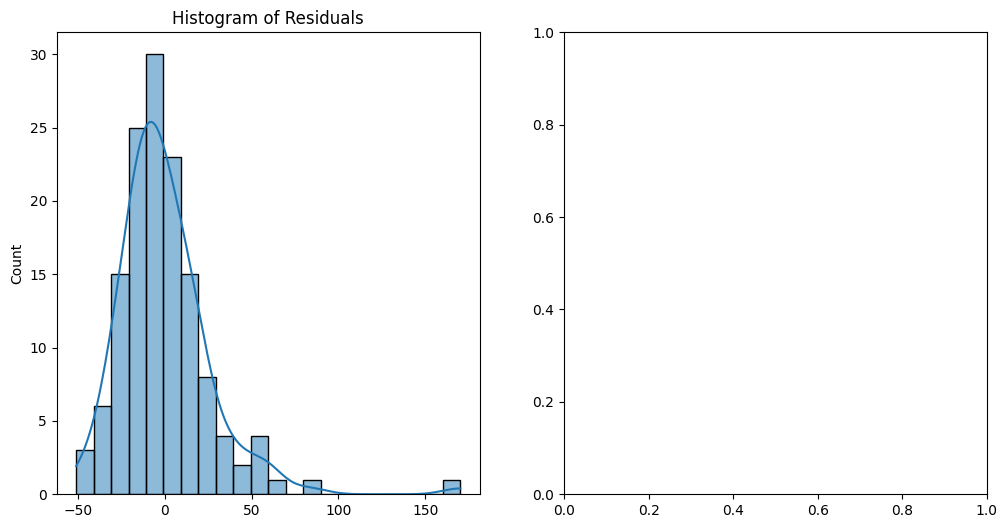

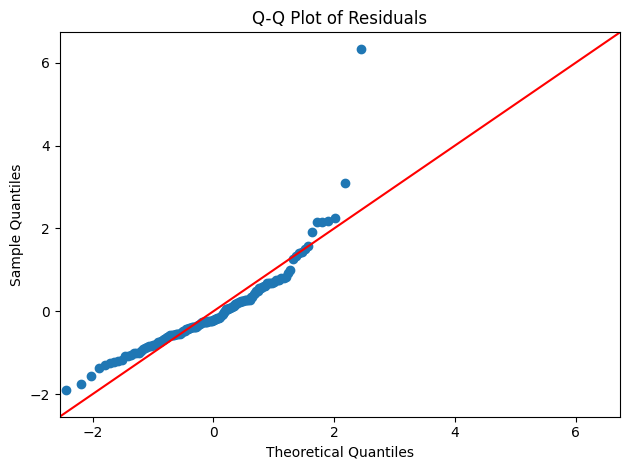

Shapiro-Wilk test: statistic=0.8522910823546673, p-value=1.940644520063229e-10
Variance Inflation Factors (VIF)
                feature        VIF
0                 const   8.690767
1             car_count   1.103428
2         wind_velocity   1.155154
3         temperature_1  53.545286
4        temperature_30  52.436281
5    day_of_week_Monday   1.237248
6    day_of_week_Sunday   1.176720
7  day_of_week_Thursday   1.202628
8   day_of_week_Tuesday   1.235801

Conclusions:
1. Test for Linearity: Null hypothesis ie. a p-value > 0.05 in the Rainbow test suggests linearity of the model.
rainbow_p_value: 0.013765778119068532
RESULTS: Reject the null hypothesis, there are indications that a non-linear model might be more suitable
--------------------------------------------
Note: The name 'rainbow test' derives from the visualization technique that might be used in plotting residuals, which could reveal a pattern resembling a rainbow if nonlinearity is present.
If the rainbow test indicates n

In [788]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, pearsonr

# Assuming 'df' is your DataFrame already loaded with the data
# X = df[['predictor1', 'predictor2', 'predictor3']]  # List your predictors
# y = df['response_variable']  # Response variable
X = df_train[list_best_predictors]
y = df_train['y']

# Adding a constant for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

# 1. Linearity Test
# Plotting the observed vs predicted values
plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, y, alpha=0.5)
plt.plot(y, y, color='red')  # Line showing perfect prediction
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.title('Check for Linearity: Observed vs Predicted Values')
plt.show()

# Testing linearity formally using Rainbow test
from statsmodels.stats.diagnostic import linear_rainbow
rainbow_stat, rainbow_p_value = linear_rainbow(model)
print(f"Rainbow test statistic: {rainbow_stat}, p-value: {rainbow_p_value}")

# 2. Homoscedasticity Test
# Residuals vs Fitted values plot
residuals = model.resid
plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Homoscedasticity Check)')
plt.show()

# Breusch-Pagan test for homoscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, model.model.exog)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
breusch_pagan_results = dict(zip(labels, bp_test))
print(breusch_pagan_results)

# 3. Independence Test
# Durbin-Watson test for independence
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat} (Values close to 2 indicate no autocorrelation)")

# 4. Normality Test of Residuals
# Histogram and Q-Q plot
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')

plt.subplot(122)
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

# 5. Multicollinearity Test
# VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors (VIF)")
print(vif_data)

# Conclusion of results printed
print("\nConclusions:")

print("1. Test for Linearity: Null hypothesis ie. a p-value > 0.05 in the Rainbow test suggests linearity of the model.")
print(f"rainbow_p_value: {rainbow_p_value}")
if rainbow_p_value > 0.05:
    print("RESULTS: Accept the null hypothesis, there is not enough proof that this is a non-linear model ie. this is a linear model.")
else:
    print("RESULTS: Reject the null hypothesis, there are indications that a non-linear model might be more suitable")

print("--------------------------------------------")
print("Note: The name 'rainbow test' derives from the visualization technique that might be used in plotting residuals, which could reveal a pattern resembling a rainbow if nonlinearity is present.")
print("If the rainbow test indicates nonlinearity, you might need to consider transforming the variables, adding polynomial terms, or trying a different type of regression model that can better handle nonlinearity, such as spline regression or generalized additive models.")

print("--------------------------------------------")

print("2. Test for Homoscedasticity: Null hypothesis ie. a p-value > 0.05 in the Breusch-Pagan test suggests homoscedastic residuals.")
print(f"breusch_pagan_results['p-value']: {breusch_pagan_results['p-value']}")
if breusch_pagan_results['p-value'] > 0.05:
    print("RESULTS: Accept the null hypothesis, the Breusch-Pagan test suggests homoscedastic residuals ie. there is constant variance of the residuals across all levels of the independent variables. ")
else:
    print("RESULTS: Reject the null hypothesis, the Breusch-Pagan test suggests homoscedastic residuals ie. there is NOT constant variance of the residuals across all levels of the independent variables.")

print("--------------------------------------------")
print("Note: Heteroscedasticity occurs when the variance of the residuals is not constant across all levels of the independent variable, which violates one of the key assumptions of linear regression and can affect the reliability of the regression results, particularly the standard errors and confidence intervals.")
print("If the Breusch-Pagan test indicates the presence of heteroscedasticity, it suggests that the standard errors derived from the ordinary least squares (OLS) estimation may not be reliable. This can lead to incorrect conclusions about the significance of the predictors. To address this, you might consider: Using robust standard errors that adjust for heteroscedasticity. Transforming dependent or independent variables (e.g., using a logarithmic transformation). Employing different estimation techniques, such as weighted least squares (WLS), which can provide more reliable estimates under conditions of heteroscedasticity.")

print("--------------------------------------------")

print("3. Test for Independence: A Durbin-Watson statistic around 2 suggests no autocorrelation. (0 suggests positive autocorrelation ie. positive error in one period carries over into a positive error in the next period, 4 suggests negative autocorrelation ie. a negative error is followed by another negative error)")
print(f"Durbin-Watson test statistic: {dw_stat}")

print("--------------------------------------------")
print("Note: Autocorrelation, also known as serial correlation, occurs when the residuals are not independent from one another, specifically when the current value of the residual is correlated with its previous values. This is a common issue in time series data but can also appear in other types of data.\nInterpretation of the Statistic: The value of the Durbin-Watson statistic typically ranges from 0 to 4. A value of 2 indicates no autocorrelation. Values approaching 0 suggest positive autocorrelation, and values toward 4 indicate negative autocorrelation.")
print("Handling Autocorrelation: If the Durbin-Watson test indicates significant autocorrelation, it can affect the reliability of the regression model’s estimates. To address this, you might: Use different modeling techniques such as Generalized Least Squares (GLS) that account for autocorrelation. Include lagged variables or difference the series in the model. Apply robust standard errors that adjust for autocorrelation.")

print("--------------------------------------------")

print("4. Test for Normality: A p-value > 0.05 in the Shapiro-Wilk test suggests residuals are normally distributed.")
print(f"Shapiro-Wilk p-value: {shapiro_p}")
if shapiro_p > 0.05:
    print("RESULTS: Accept the null hypothesis, residuals are normally distributed")
else:
    print("RESULTS: Accept the null hypothesis, residuals are NOT normally distributed")

print("--------------------------------------------")
print("Note: The Shapiro-Wilk test is a statistical test used to assess the normality of a dataset.")
print("This is crucial in statistics because many tests, like the t-test and ANOVA, assume normality in their calculations.")
print("It's one of the more powerful normality tests available, often preferred over other tests like the Kolmogorov-Smirnov test, especially when dealing with small sample sizes.")

print("--------------------------------------------")

print("5. Test for Multicollinearity: VIF values < 10 suggest no multicollinearity issues among predictors.")
print(f"Results from VIF")
for row in vif_data.to_dict('records'):
    # print(row)
    variable = row['feature']
    vif_value = row['VIF']
    print(f"variable: {variable}")
    print(f"vif_value: {vif_value}")
    if vif_value <= 1:
        print("no correlation between the predictor and the other variables.")
    if vif_value > 1 and vif_value <= 5:
        print("moderate correlation, but it is often not severe enough to require attention.")
    if vif_value > 5:
        print("problematic levels of multicollinearity. Higher values signify higher multicollinearity, meaning the variable is highly predictable from the others.")
    print("------")

print("--------------------------------------------")
print("Note: For each predictor variable in a regression model, VIF is calculated by regressing that predictor against all the other predictor variables. This process is repeated for each predictor variable in the model.")
print("VIF helps in identifying variables that are redundant or too closely linked to one or more other variables. This can be particularly useful in large datasets with many predictors. [A VIF of 1 indicates no correlation between the predictor and the other variables. A VIF between 1 and 5 usually suggests a moderate correlation, but it is often not severe enough to require attention. A VIF greater than 5 or 10 (different thresholds are used in practice) may indicate problematic levels of multicollinearity. Higher values signify higher multicollinearity, meaning the variable is highly predictable from the others.]")
print("VIF is a handy diagnostic tool for assessing predictor variables and ensuring that the regression model you develop provides meaningful and reliable results.")

In [789]:
# validate_assumptions_of_linear_regression():
#     """
#     """
#     pass
